### Sensitivity Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

##### Negative Outcome Control

In [18]:
df_lr = df.copy()
prop_formula = "CITIZEN ~ AGE + C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND)"

prop_model = smf.logit(prop_formula, data=df_lr).fit(disp=False)
df_lr["e_hat"] = prop_model.predict(df)
df_lr["e_hat"] = df_lr["e_hat"].clip(0.01, 0.99)
df_lr.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.913634
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.913634
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.913634
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.592551
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104,0.143931


In [ ]:
target_placebo = "AGE"
# Remove AGE from the covariates list
covariates = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND", "YEARS_IN_US"]


df_robust = df.copy()
# for col in ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]:
#     treated_vals = set(df_robust[df_robust["CITIZEN"] == 1][col].unique())
#     control_vals = set(df_robust[df_robust["CITIZEN"] == 0][col].unique())
#     common = treated_vals.intersection(control_vals)
#     df_robust = df_robust[df_robust[col].isin(common)]

print(f"Data rows after filtering: {len(df_robust)}")


prop_formula = "CITIZEN ~ " + " + ".join([f"C({c})" if c not in ["YEARS_IN_US"] else c for c in covariates])
prop_model = smf.logit(prop_formula, data=df_robust).fit(disp=False)

df_robust["e_hat"] = prop_model.predict(df_robust)
df_robust["e_hat"] = df_robust["e_hat"].clip(0.01, 0.99)

outcome_formula = f"{target_placebo} ~ " + " + ".join([f"C({c})" if c not in ["YEARS_IN_US"] else c for c in covariates])

m1_model = smf.ols(outcome_formula, data=df_robust[df_robust["CITIZEN"] == 1]).fit()
m0_model = smf.ols(outcome_formula, data=df_robust[df_robust["CITIZEN"] == 0]).fit()

m1_hat = m1_model.predict(df_robust)
m0_hat = m0_model.predict(df_robust)

T = df_robust["CITIZEN"].values
Y = df_robust[target_placebo].values
e = df_robust["e_hat"].values

psi_placebo = (
    m1_hat - m0_hat
    + T * (Y - m1_hat) / e
    - (1 - T) * (Y - m0_hat) / (1 - e)
)

print(f"Placebo Test (Effect on Age): {psi_placebo.mean():.4f}")
print(f"Std Error: {psi_placebo.std() / np.sqrt(len(psi_placebo)):.4f}")

if abs(psi_placebo.mean()) < 0.5: 
    print("PASS: No meaningful effect on Age found.")
else:
    print("FAIL: Significant effect on Age found. Selection bias persists.")

Data rows after filtering: 223798
Placebo Test (Effect on Age): -0.0687
Std Error: 0.0726
PASS: No meaningful effect on Age found.


In [ ]:

target_variable = "AGE"

df_rf = df.copy()
df_rf.head()

for col in ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]:
    treated_vals = set(df_rf[df_rf["CITIZEN"] == 1][col].unique())
    control_vals = set(df_rf[df_rf["CITIZEN"] == 0][col].unique())
    common = treated_vals.intersection(control_vals)
    df_rf = df_rf[df_rf[col].isin(common)]

cat_vars = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]
X = pd.get_dummies(df_rf[["YEARS_IN_US"] + cat_vars], drop_first=True)
T = df_rf["CITIZEN"].values
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=20,
    random_state=0,
    n_jobs=-1
)
rf.fit(X, T)
df_rf["e_hat"] = rf.predict_proba(X)[:, 1]
df_rf["e_hat"] = df_rf["e_hat"].clip(0.01, 0.99)


outcome_formula = "AGE ~  C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND)"
m1_model = smf.ols(outcome_formula, data=df_rf[df_rf["CITIZEN"] == 1]).fit()
m0_model = smf.ols(outcome_formula, data=df_rf[df_rf["CITIZEN"] == 0]).fit()


df_rf["m1_hat"] = m1_model.predict(df_rf)
df_rf["m0_hat"] = m0_model.predict(df_rf)


T = df_rf["CITIZEN"].values
Y = df_rf[target_variable].values
e = df_rf["e_hat"].values
m1 = df_rf["m1_hat"].values
m0 = df_rf["m0_hat"].values

psi = (
    m1 - m0
    + T * (Y - m1) / e
    - (1 - T) * (Y - m0) / (1 - e)
)


effect = psi.mean()
se = psi.std(ddof=1) / np.sqrt(len(psi))

print("-" * 30)
print(f"PLACEBO TEST RESULT (Random Forest AIPW on AGE):")
print(f"Estimated Effect: {effect:.4f} years")
print(f"Standard Error:   {se:.4f}")

lower_ci = effect - 1.96 * se
upper_ci = effect + 1.96 * se
print(f"95% CI:           [{lower_ci:.4f}, {upper_ci:.4f}]")

if lower_ci <= 0 <= upper_ci:
    print("PASS: The effect is statistically indistinguishable from zero.")
else:
    print("FAIL: Significant imbalance in Age remains.")
print("-" * 30)

------------------------------
PLACEBO TEST RESULT (Random Forest AIPW on AGE):
Estimated Effect: -0.0168 years
Standard Error:   0.0355
95% CI:           [-0.0864, 0.0529]
PASS: The effect is statistically indistinguishable from zero.
------------------------------


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

target_variable = "AGE"

df_nn = df.copy()
cat_vars = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]
X_cat = pd.get_dummies(df_nn[cat_vars], drop_first=True)
X_cont = df_nn[["YEARS_IN_US"]].copy()
scaler = StandardScaler()
X_cont_scaled = pd.DataFrame(
    scaler.fit_transform(X_cont),
    columns=X_cont.columns,
    index=X_cont.index
)
X = pd.concat([X_cont_scaled, X_cat], axis=1)
T = df_nn["CITIZEN"].values

rf_seed = 42 
mlp = MLPClassifier(
    hidden_layer_sizes=(32,),
    solver="adam",
    alpha=1e-4,
    batch_size="auto",
    learning_rate="adaptive",
    max_iter=200,
    random_state=rf_seed,
    early_stopping=True,
    n_iter_no_change=5,
    verbose=False
)

mlp.fit(X, T)

df_nn["e_hat"] = mlp.predict_proba(X)[:, 1]

df_nn["e_hat"] = df_nn["e_hat"].clip(0.01, 0.99)

outcome_formula = "AGE ~  C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND)"

m1_model = smf.ols(outcome_formula, data=df_nn[df_nn["CITIZEN"] == 1]).fit()
m0_model = smf.ols(outcome_formula, data=df_nn[df_nn["CITIZEN"] == 0]).fit()

df_nn["m1_hat"] = m1_model.predict(df_nn)
df_nn["m0_hat"] = m0_model.predict(df_nn)


T = df_nn["CITIZEN"].values
Y = df_nn[target_variable].values
e = df_nn["e_hat"].values
m1 = df_nn["m1_hat"].values
m0 = df_nn["m0_hat"].values

psi = (
    m1 - m0
    + T * (Y - m1) / e
    - (1 - T) * (Y - m0) / (1 - e)
)

tau_hat = psi.mean()
se_hat = psi.std(ddof=1) / np.sqrt(len(psi))

print("-" * 30)
print(f"PLACEBO TEST (Neural Net AIPW on AGE):") 
print(f"Estimated Effect: {tau_hat:.4f} years")  
print(f"Standard Error:   {se_hat:.4f}")

ci_low = tau_hat - 1.96 * se_hat
ci_high = tau_hat + 1.96 * se_hat
print(f"95% CI:           [{ci_low:.4f}, {ci_high:.4f}]")

if ci_low <= 0 <= ci_high:
    print("PASS: The effect is statistically indistinguishable from zero.")
else:
    print("FAIL: Significant imbalance in Age remains.")
print("-" * 30)

------------------------------
PLACEBO TEST (Neural Net AIPW on AGE):
Estimated Effect: 0.2293 years
Standard Error:   0.0645
95% CI:           [0.1028, 0.3558]
FAIL: Significant imbalance in Age remains.
------------------------------


##### Cordnfield's Type Sensitivity Analysis #####

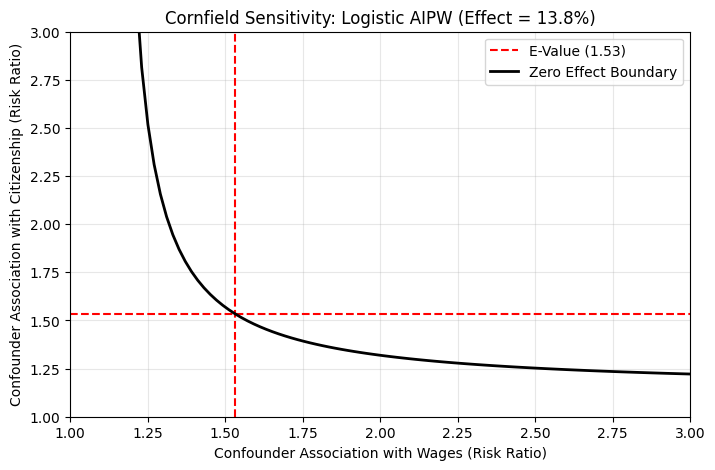

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cornfield_logistic():
    beta = 0.1290 
    RR_obs = np.exp(beta)
    e_val = RR_obs + np.sqrt(RR_obs * (RR_obs - 1))
    
    plt.figure(figsize=(8, 5))
    
    plt.plot([1, 3], [e_val, e_val], 'r--', label=f'E-Value ({e_val:.2f})')
    plt.plot([e_val, e_val], [1, 3], 'r--')
    
    rr_uy = np.linspace(1.01, 3, 100) 

    valid_curve = rr_uy > RR_obs
    rr_tu = (RR_obs * (rr_uy[valid_curve] - 1)) / (rr_uy[valid_curve] - RR_obs)
    
    plt.plot(rr_uy[valid_curve], rr_tu, 'k-', linewidth=2, label='Zero Effect Boundary')
    
    plt.xlabel("Confounder Association with Wages (Risk Ratio)")
    plt.ylabel("Confounder Association with Citizenship (Risk Ratio)")
    plt.title(f"Cornfield Sensitivity: Logistic AIPW (Effect = 13.8%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(1, 3)
    plt.xlim(1, 3)
    plt.show()

plot_cornfield_logistic()

###### SPEAKING

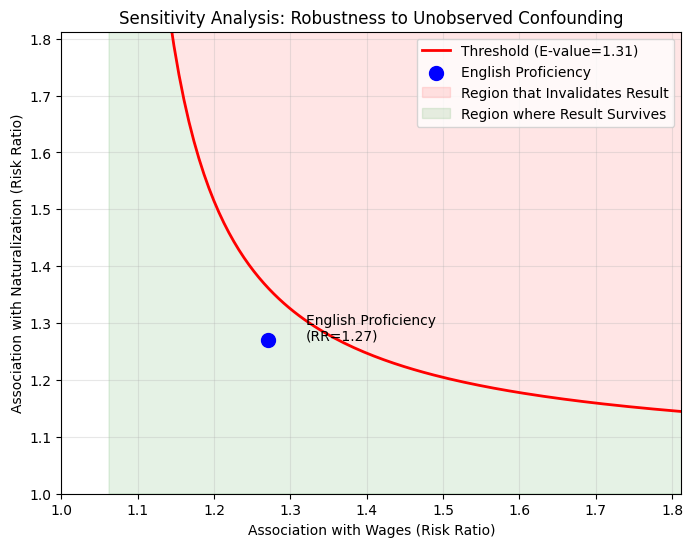

In [ ]:
def plot_cornfield_curve(observed_RR, benchmark_RR, benchmark_name="English"):
    e_value = observed_RR + np.sqrt(observed_RR * (observed_RR - 1))
    
    plt.figure(figsize=(8, 6))
    
  
    x = np.linspace(1.01, e_value + 1, 200)
   
    y = (observed_RR * (x - 1)) / (x - observed_RR)
    
    mask = (x > observed_RR) & (y > 1)
    plt.plot(x[mask], y[mask], color='red', lw=2, label=f'Threshold (E-value={e_value:.2f})')
    
    plt.scatter([benchmark_RR], [benchmark_RR], color='blue', s=100, zorder=5, label=benchmark_name)
    plt.text(benchmark_RR+0.05, benchmark_RR, f"{benchmark_name}\n(RR={benchmark_RR:.2f})")
    
    plt.fill_between(x[mask], y[mask], max(y), color='red', alpha=0.1, label="Region that Invalidates Result")
    plt.fill_between(x[mask], 1, y[mask], color='green', alpha=0.1, label="Region where Result Survives")

    plt.xlabel("Association with Wages (Risk Ratio)")
    plt.ylabel("Association with Naturalization (Risk Ratio)")
    plt.title(f"Sensitivity Analysis: Robustness to Unobserved Confounding")
    plt.xlim(1, e_value + 0.5)
    plt.ylim(1, e_value + 0.5)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_cornfield_curve(1.06, 1.27, "English Proficiency")

In [ ]:
import numpy as np
import statsmodels.formula.api as smf

# Benchmarking R^2

est_effect = 0.064   
std_error  = 0.0034  
sample_size = len(df) 
dof = sample_size - 8 - 1  

t_stat = est_effect / std_error
partial_r2_treatment = (t_stat**2) / (t_stat**2 + dof)

print(f"AIPW t-statistic: {t_stat:.4f}")
print(f"Partial R2 of Treatment: {partial_r2_treatment:.6f}")


rv = 0.5 * (np.sqrt(partial_r2_treatment**2 + 4 * partial_r2_treatment) - partial_r2_treatment)
print(f"Robustness Value (RV): {rv:.4f} (or {rv*100:.1f}%)")


print("\n--- BENCHMARKING AGAINST EDUCATION ---")


benchmark_formula = "INCWAGE_LOG ~ AGE+ C(CITIZEN) + C(EDUC) + C(SEX) + C(RACE) + C(MARST) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND)"
bench_model = smf.ols(benchmark_formula, data=df).fit()


t_educ = bench_model.tvalues.filter(like="EDUC").abs().max()
r2_educ = (t_educ**2) / (t_educ**2 + dof)

print(f"Max t-statistic for EDUC: {t_educ:.4f}")
print(f"Partial R2 of EDUC: {r2_educ:.6f} (or {r2_educ*100:.1f}%)")


ratio = rv / r2_educ
print(ratio)


AIPW t-statistic: 18.8235
Partial R2 of Treatment: 0.001581
Robustness Value (RV): 0.0390 (or 3.9%)

--- BENCHMARKING AGAINST EDUCATION ---
Max t-statistic for EDUC: 45.0090
Partial R2 of EDUC: 0.008971 (or 0.9%)
4.344688062172787


In [ ]:
# Rosenbaum bounds

gammas = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

for g in gammas:
    p_upper = rosenbaum_bounds(diffs, gamma=g)
    
    sig_status = "Significant" if p_upper < 0.05 else "Not Significant"
    
    print(f"{g:<10.1f} | {p_upper:.4f}               | {sig_status}")
    
    if p_upper > 0.05:
        print(g)
        break

1.0        | 0.0000               | Significant
1.1        | 0.7368               | Not Significant
1.1


In [ ]:
import numpy as np
import pandas as pd

# E-Value

results = {
    "Linear Regression (OR)": [0.079, 0.0040],
    "Logistic AIPW":          [0.138, 0.0088],
    "Random Forest AIPW":     [0.064, 0.0034],
    "Neural Network AIPW":    [0.087, 0.0070],
    "Matching (1:1)":         [0.049, 0.0040],
    "Matching (1:M)":         [0.047, 0.0034]
}

def calculate_e_value(beta, se):
   
    rr_point = np.exp(abs(beta))
    
    e_point = rr_point + np.sqrt(rr_point * (rr_point - 1))
    

    limit = abs(beta) - 1.96 * se
    
    if limit <= 0:
        return e_point, 1.0 
        
    rr_limit = np.exp(limit)
    e_ci = rr_limit + np.sqrt(rr_limit * (rr_limit - 1))
    
    return e_point, e_ci

rows = []
for method, stats in results.items():
    beta, se = stats
    e_est, e_ci = calculate_e_value(beta, se)
    
    sig = "*" if (abs(beta) - 1.96*se) > 0 else "NS"
    
    rows.append({
        "Method": method,
        "Estimate": f"{beta:.1%}",
        "E-Value (Est)": f"{e_est:.2f}",
        "E-Value (CI)": f"{e_ci:.2f}",
        "Sig": sig
    })

df_robustness = pd.DataFrame(rows)
print(df_robustness)

                   Method Estimate E-Value (Est) E-Value (CI) Sig
0  Linear Regression (OR)     7.9%          1.38         1.36   *
1           Logistic AIPW    13.8%          1.56         1.51   *
2      Random Forest AIPW     6.4%          1.33         1.31   *
3     Neural Network AIPW     8.7%          1.41         1.36   *
4          Matching (1:1)     4.9%          1.28         1.25   *
5          Matching (1:M)     4.7%          1.27         1.25   *
